In [1]:
%pylab inline
from __future__ import print_function, division

import os
import os.path as osp
import matplotlib.pyplot as plt

from warnings import warn
import datetime, time
import glob as gb
from six import string_types
import argparse
import json
import time
import re

import numpy as np
import scipy.linalg as lin
import scipy.stats as sst

import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import smpce_data_to_corr as smp
import layout as lo
import utils._utils as ucr
import correlation2results as c2r
import signals2results as s2r

In [3]:
np.set_printoptions(precision=3)
lo = reload(lo)
ucr = reload(ucr)
smp = reload(smp)
c2r = reload(c2r)
s2r = reload(s2r)

## Read the signals, form a correlation matrix

In [4]:
# get the list of npz corresponding to a specific analysis
# use directory layout for this 
dbase = '/home/jb/data/simpace/rename_files'
pipelines = [None, 'NR_0', 'NR_1', 'NR_2', 'NR_3', 'NR_4', 'NR_5', 'NR_6', 'WMr']
pipeline_dic = {'NR_0':'m_CSF+WM', 
                'NR_1':'m_CSF+WM+GS', 
                'NR_2':'pc_CSF+WM', 
                'NR_3':'pc_CSF+WM+GS', 
                'NR_4':'Filt-only',
                'NR_5':'HPF+CCor',
                'NR_6':'HPF+CCor+GS', 
                'WMr':'WMlocal'}
assert s2r.test_get_npz_filenames(dbase)
assert s2r.test_get_conds_filenames(dbase, pipelines)
ordered_conds = s2r.ordered_conds()

np.set_printoptions(precision=3)

order_pipe = ['NR_4', 'NR_0', 'NR_1', 'NR_2', 'NR_3', 'NR_5', 'NR_6', 'WMr']
order_nicepipe = [pipeline_dic[p] for p in order_pipe]

### Testing getting data from pipeline

In [5]:
def abs_mean(arr):
    return np.mean(np.abs(arr),axis=1)


In [14]:

def do_one_pipe(dbase, pipe, pipeline_dic):
    
    conds_files, pipeline = s2r.get_conds_filenames(dbase, addjson=pipe, 
                                                    pipeline_dic=pipeline_dic)
    common_labels = s2r._get_common_labels(conds_files, idx0=1)
    conds_arr, stored_params = s2r.compute_corr_mtx(conds_files, common_labels)
    # print([(k,conds_arr[k].shape) for k in ordered_conds])
    labels = conds_arr['labels']
    conds_arr.pop('labels')

    zconds_arr = s2r.conds_2_zconds(conds_arr, ordered_conds)
    # print([(k,zconds_arr[k].shape) for k in ordered_conds])
    zconds_minus_none = s2r.remove_cond(zconds_arr, ordered_conds, remove='none')
    # print('zconds_minus_none.keys', zconds_minus_none.keys())
    zconds_abs_mean = s2r.summary_per_zconds(zconds_minus_none, abs_mean)
    corr_none = s2r.summary_correlation(zconds_arr)
    #print(corr_none)
    
    pipe_abs_mean = {}
    pipe_corr_none = {}
    std_this_cond = {}
    for c in ordered_conds:
        # std across sessions : axis=0, then mean/median across npairs
        std_this_cond[c] = np.median(np.std(zconds_arr[c], axis=0))
        pipe_abs_mean[c] = zconds_abs_mean[c]
        pipe_corr_none[c] = corr_none[c]

        to_print = "cond:{0:5s} bias: {1:5.3f}({2:04.3f}) std: {3:04.3f} corr {4:5.3f}({5:04.3f})"

        print(to_print.format(c, zconds_abs_mean[c].mean(), zconds_abs_mean[c].std(), 
                              std_this_cond[c], corr_none[c].mean(), corr_none[c].std()))
    
    return({'abs_mean':pipe_abs_mean, 'corr_none':pipe_corr_none, 'std':std_this_cond})
    

In [15]:
all_pipes = pipelines[1:]
pipe_res = {}
for pipe in all_pipes:
    pipe_res[pipeline_dic[pipe]] = do_one_pipe(dbase, pipe, pipeline_dic)

measures = pipe_res[pipeline_dic[pipe]].keys()
print(measures)

cond:none  bias: 0.000(0.000) std: 0.204 corr 1.000(0.000)
cond:low   bias: 0.223(0.019) std: 0.190 corr 0.642(0.059)
cond:med   bias: 0.252(0.056) std: 0.225 corr 0.606(0.081)
cond:high  bias: 0.250(0.023) std: 0.183 corr 0.527(0.067)
cond:none  bias: 0.000(0.000) std: 0.196 corr 1.000(0.000)
cond:low   bias: 0.235(0.020) std: 0.187 corr 0.625(0.054)
cond:med   bias: 0.234(0.020) std: 0.184 corr 0.609(0.071)
cond:high  bias: 0.244(0.014) std: 0.168 corr 0.533(0.053)
cond:none  bias: 0.000(0.000) std: 0.208 corr 1.000(0.000)
cond:low   bias: 0.236(0.021) std: 0.201 corr 0.592(0.066)
cond:med   bias: 0.242(0.044) std: 0.201 corr 0.577(0.095)
cond:high  bias: 0.252(0.016) std: 0.187 corr 0.512(0.061)
cond:none  bias: 0.000(0.000) std: 0.202 corr 1.000(0.000)
cond:low   bias: 0.239(0.014) std: 0.199 corr 0.608(0.050)
cond:med   bias: 0.232(0.021) std: 0.189 corr 0.612(0.070)
cond:high  bias: 0.249(0.019) std: 0.183 corr 0.522(0.058)
cond:none  bias: 0.000(0.000) std: 0.231 corr 1.000(0.00

In [16]:
import collections

def plot_summary(pipe_res, cond, mkey, order=order_nicepipe, nsess=13):
    
    all_pipes = pipe_res.keys()
    data_dic = {}
    data_dic['pipelines'] = []
    data_dic[mkey] = []
    
    for pipe in all_pipes:
        # nicepipe = pipeline_dic[pipe]
        try:
            data_dic[mkey] += list(pipe_res[pipe][mkey][cond])
            data_dic['pipelines'] += [pipe]*nsess

        except:
            # print(pipe_res[pipe][mkey][cond])
            data_dic[mkey] += [pipe_res[pipe][mkey][cond]]
            data_dic['pipelines'] += [pipe]
            
    # data_dic['abs_mean']
    # data_dic['pipelines']

    this_pd = pd.DataFrame.from_dict(data_dic, orient='columns') # , dtype=formats)
    plt.subplots_adjust(top=0.9)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax_ = sns.boxplot(x="pipelines", y=mkey, data=this_pd, palette="PRGn", ax=ax1, order=order)
    ax_.set_title(cond)
    
    return f

#axes = plot_summary(pipe_res, cond, mkey)
#type(fig)

['std', 'abs_mean', 'corr_none']


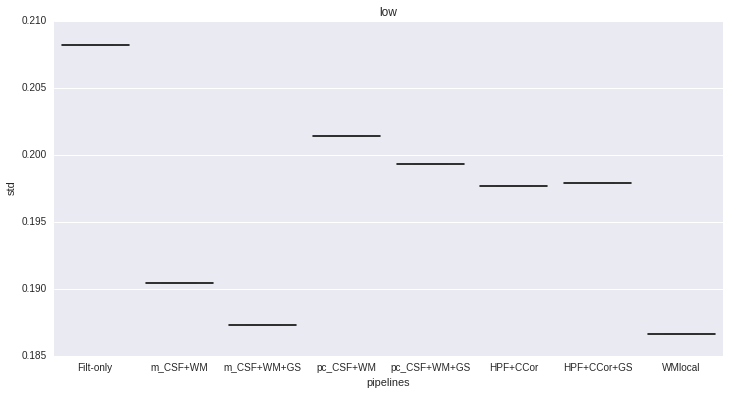

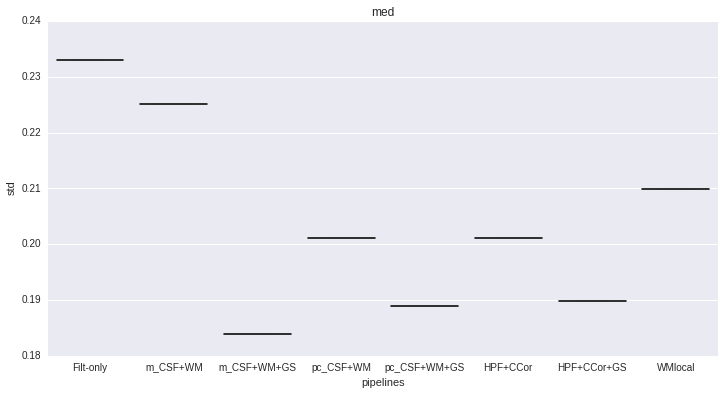

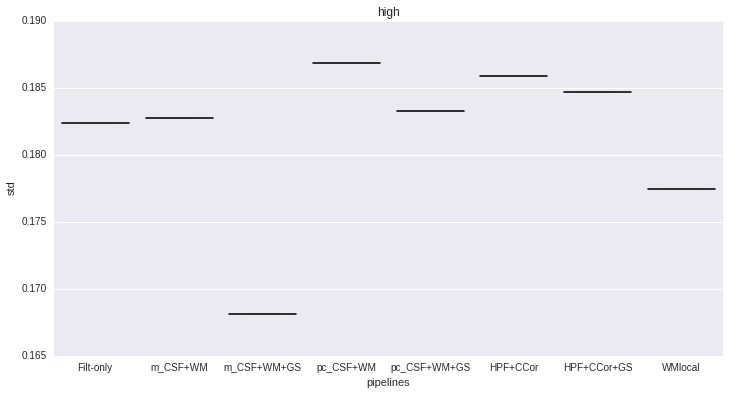

In [17]:
print(measures)
mkey = 'std'
for cond in ordered_conds:
    if cond != 'none': axes = plot_summary(pipe_res, cond, mkey)


In [66]:
np.set_printoptions(precision=3)


ordered_conds = s2r.ordered_conds()
ordered_pipelines = [None, 'NR_4', 'NR_0', 'NR_1', 'NR_2', 'NR_3', 'NR_5', 'NR_6', 'WMr']

assert check_npz_files(dbase, pipelines, nsess=13, ncond=4)

for pipe in ordered_pipelines:
    conds, pipeline = s2r.create_conds_filenames(dbase, addjson=pipe, pipeline_dic=pipeline_dic)
    common_labels = s2r._get_common_labels(conds, idx0=1)
    conds_arr, stored_params = s2r.compute_corr_mtx(conds, common_labels)
    bias, stdev = s2r.smpce_bias_std(conds_arr, ordered_conds)

    print('pipeline:', pipeline)
    print('-'*77)
    for k in ordered_conds:
        #bias, std = s2r.smpce_mean_cond(conds_arr, k)
        avrg = conds_arr[k].mean(axis=0)
        to_print = "{0:5s}: {1:5.2f} mean: {2:03.2f} mean(abs): {3:04.3f} " +  \
                    "std(norm): {4:5.2f} std(mean) {5:5.3f}"
        print(to_print.format(
                k,  lin.norm(bias[k]), avrg.mean(), np.abs(avrg).mean(), 
                    lin.norm(stdev[k]), stdev[k].mean()))
        #print('check', vari[k][[1,2,3,4],[1,2,3,4]]) #  bias[k].shape,
    print("\n")

pipeline: default
-----------------------------------------------------------------------------
none :  0.00 mean: 0.46 mean(abs): 0.458 std(norm): 12.98 std(mean) 0.147
low  :  5.66 mean: 0.46 mean(abs): 0.461 std(norm): 12.25 std(mean) 0.141
med  :  7.54 mean: 0.44 mean(abs): 0.444 std(norm): 11.69 std(mean) 0.135
high : 12.56 mean: 0.39 mean(abs): 0.393 std(norm):  8.82 std(mean) 0.102


pipeline: Filt-only
-----------------------------------------------------------------------------
none :  0.00 mean: 0.54 mean(abs): 0.544 std(norm): 13.83 std(mean) 0.149
low  :  5.64 mean: 0.53 mean(abs): 0.533 std(norm): 12.98 std(mean) 0.142
med  :  7.24 mean: 0.52 mean(abs): 0.518 std(norm): 14.32 std(mean) 0.157
high : 11.82 mean: 0.46 mean(abs): 0.460 std(norm): 12.31 std(mean) 0.135


pipeline: m_CSF+WM
-----------------------------------------------------------------------------
none :  0.00 mean: 0.39 mean(abs): 0.390 std(norm): 14.69 std(mean) 0.162
low  :  7.25 mean: 0.40 mean(abs): 0.39

WMlocal


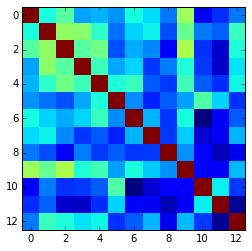

In [18]:
c = s2r.smpce_corr_btw_sess_cond(conds_arr['none'])
plt.imshow(c,interpolation='nearest',)
print(pipeline)

In [14]:

def plot_pipeline_summary(conds_summary, title, pipeline=None, minall=-.4, maxall=.4):

    f, axes = plt.subplots(1, 4, sharey=True, figsize=(18,4))
    f.subplots_adjust(wspace=0.1)
    f.subplots_adjust(right=0.85)
    titlestr = 'Pipeline ' + pipeline + ' - ' + title
    f.suptitle(titlestr, fontsize=24, fontweight='bold', x=.5, y=.01)
    left, bottom, width, height = .87, 0.12, 0.02, 0.77 
    cbar_ax = f.add_axes([left, bottom, width, height])

    minall_ = np.min(np.asarray([conds_summary[k].min() for k in ordered_conds]))
    maxall_ = np.max(np.asarray([conds_summary[k].max() for k in ordered_conds]))
    if not minall: minall=minall_
    if not maxall: maxall=maxall_

    for axe,k in zip(axes,ordered_conds): 
        m = axe.imshow(conds_summary[k], interpolation='nearest', vmin=minall, vmax=maxall)
        axe.set_title(k, fontsize=20)

    cm = f.colorbar(m, cax=cbar_ax)
    return minall_, maxall_
    

(0.0, 0.36970233398466462)

/home/jb/.virtualenvs/py2/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


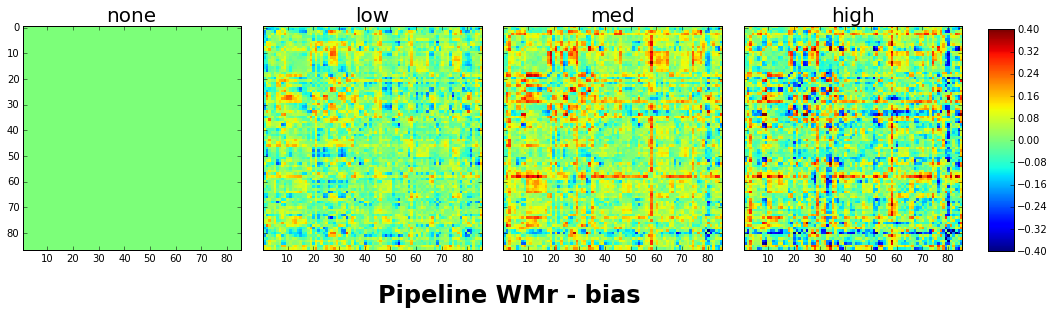

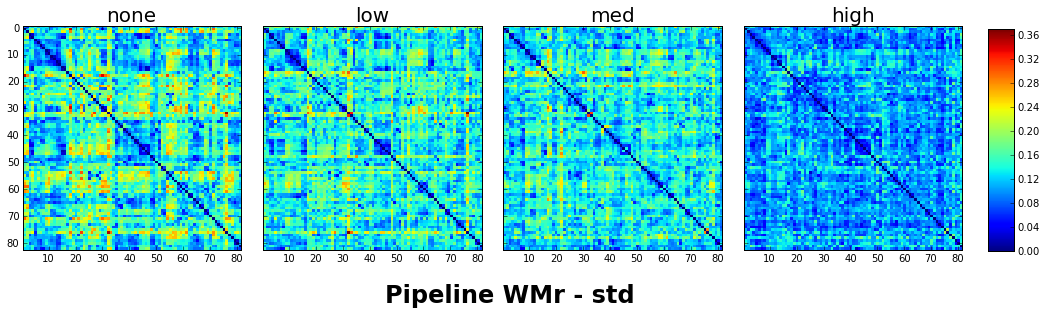

In [15]:

plot_pipeline_summary(bias, 'bias',  pipeline=pipeline)
plot_pipeline_summary(vari, 'std', pipeline=pipeline, minall=None, maxall=None)

In [16]:
for pipe in pipelines:
    conds, pipeline = s2r.create_conds_filenames(dbase, addjson=pipe)
    common_labels = s2r._get_common_labels(conds, idx0=1)
    conds_arr, stored_params = s2r.compute_corr_mtx(conds, common_labels)

    